## Libraries

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random,os
import cv2
from keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import get_file
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-08-11 15:52:50.819897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754927571.038075      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754927571.108185      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load-Data

In [2]:
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz','metal','pop','reggae','rock']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
class_names_label

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [3]:
def load_data(parent_folder, image_size=(224, 224)):
    images = []
    labels = []

    for folder in class_names:
        folder_path = os.path.join(parent_folder, folder)
        label = class_names_label[folder]

        for file in tqdm(os.listdir(folder_path), desc=f"Loading {folder}"):
            img_path = os.path.join(folder_path, file)

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)

            images.append(image)
            labels.append(label)

    return np.array(images, dtype="float32"), np.array(labels, dtype="int32")


In [4]:
# Load all data
parent_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original"
X, y = load_data(parent_path)

Loading rock: 100%|██████████| 100/100 [00:02<00:00, 45.32it/s]


## Visualize-Data

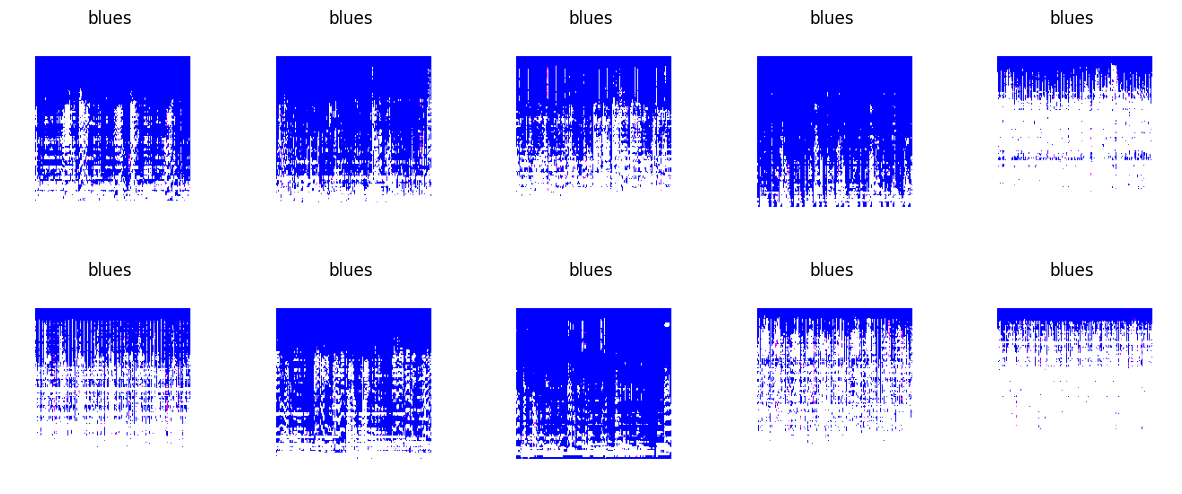

In [5]:

# Function to display sample images
def show_sample_images(X, y, class_names, rows=2, cols=5):
    plt.figure(figsize=(15, 6))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.show()

# Show 10 training images
show_sample_images(X, y, class_names)


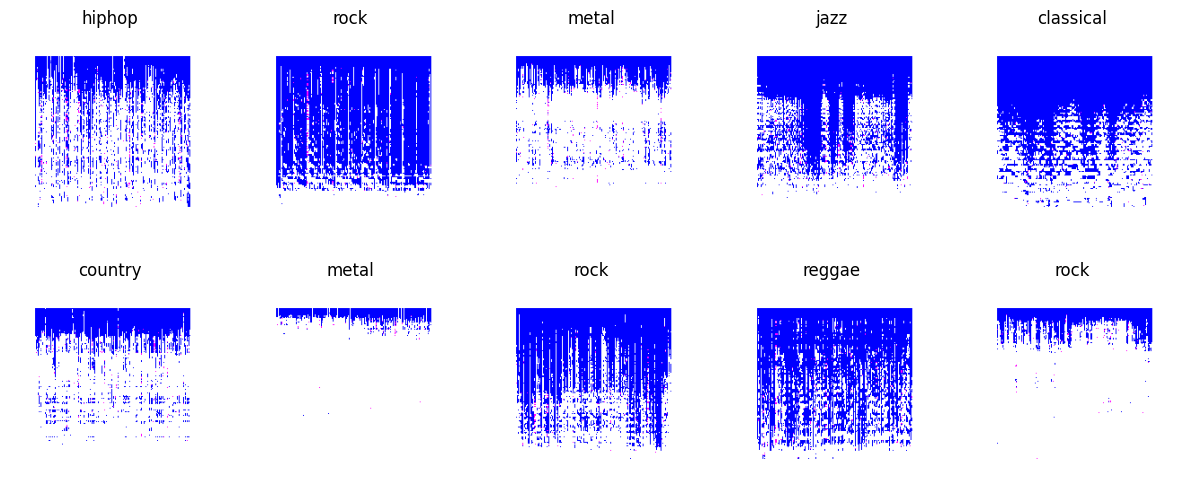

In [6]:
import numpy as np

def show_random_images(X, y, class_names, rows=2, cols=5):
    idxs = np.random.choice(len(X), rows * cols, replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[idx])
        plt.title(class_names[y[idx]])
        plt.axis('off')
    plt.show()

# Show random images
show_random_images(X, y, class_names)


## Split-Data

In [7]:
# # Normalize pixel values
# X = X / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)

Training data: (799, 224, 224, 3) (799,)
Testing data: (200, 224, 224, 3) (200,)


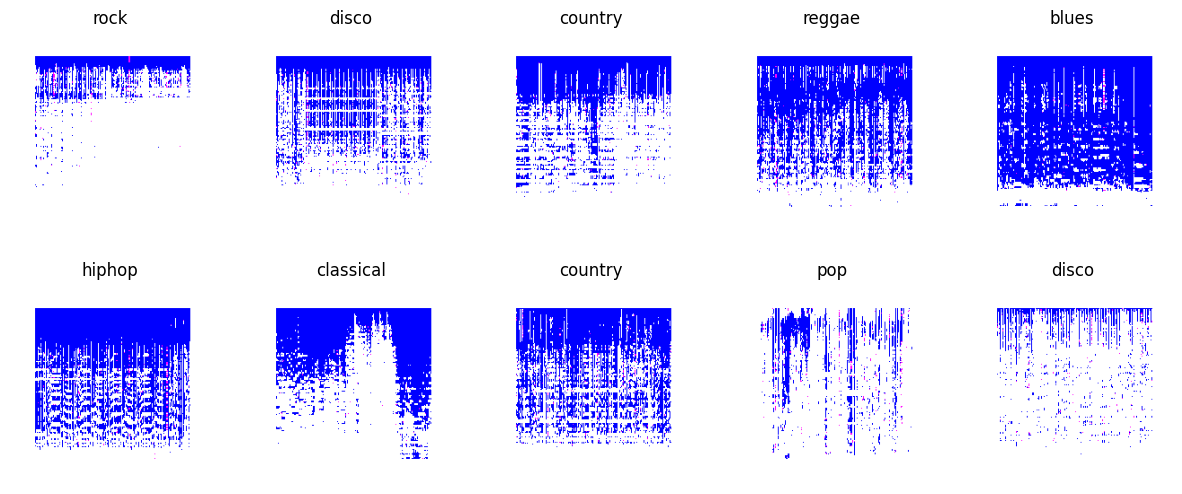

In [8]:
import numpy as np

def show_random_images(X, y, class_names, rows=2, cols=5):
    idxs = np.random.choice(len(X), rows * cols, replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(X[idx], vmin=0, vmax=1)
        plt.title(class_names[y[idx]])
        plt.axis('off')
    plt.show()

# Show random images
show_random_images(X_train, y_train, class_names)

## Preproces-Data-For-ResNet50

In [9]:
X_train_resnet = preprocess_input(X_train)
X_test_resnet = preprocess_input(X_test)


## Transfer-Learning + Model

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file

# Download weights
weights_path = get_file(
    'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    'https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
)

# Build base model without pooling
base_model = ResNet50(
    include_top=False,
    weights=weights_path,
    input_shape=(224, 224, 3))
base_model.trainable == False

# Get the actual output tensor (not tuple)
# We'll use the output of the last convolutional layer
last_conv_layer = base_model.get_layer(base_model.layers[-1].name)
x = last_conv_layer.output

# Add Global Average Pooling
x = GlobalAveragePooling2D()(x)


# Add final dense layer
output = Dense(10, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


2025-08-11 15:53:47.042247: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Preprocess-Labels

In [11]:
num_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

## Run-Model

In [12]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Observations:
- Training accuracy reaches 100% by epoch 6, while validation accuracy plateaus around 75%
- Significant gap between training and validation accuracy suggests potential overfitting

### Recommendations for Improvement:
1. **Increase number of epochs**: The validation accuracy (75.5%) shows steady improvement and might continue to increase with more training
2. **Data augmentation**: Though not required by the task, augmentation could help bridge the gap between training and validation performance
3. **Future work**: Comparative study with/without augmentation would be valuable to quantify its impact

Note: All epochs took approximately 13s/step (average 320s per epoch)

In [13]:
history = model.fit(
    X_train_resnet, y_train_cat,
    validation_data=(X_test_resnet, y_test_cat),
    epochs=10,
    batch_size=32
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 363s 12s/step - accuracy: 0.3704 - loss: 1.8191 - val_accuracy: 0.3150 - val_loss: 2.0136
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 295s 12s/step - accuracy: 0.8735 - loss: 0.4525 - val_accuracy: 0.3800 - val_loss: 1.7952
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 339s 13s/step - accuracy: 0.9739 - loss: 0.1574 - val_accuracy: 0.3600 - val_loss: 1.8916
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 309s 12s/step - accuracy: 0.9926 - loss: 0.0404 - val_accuracy: 0.5600 - val_loss: 1.3579
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 322s 13s/step - accuracy: 0.9996 - loss: 0.0224 - val_accuracy: 0.6450 - val_loss: 1.0449
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 296s 12s/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 0.6900 - val_loss: 1.0669
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 317s 13s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.7000 - val_loss: 0.9979
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 307s 12s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.

## Evaluate-Resnet50

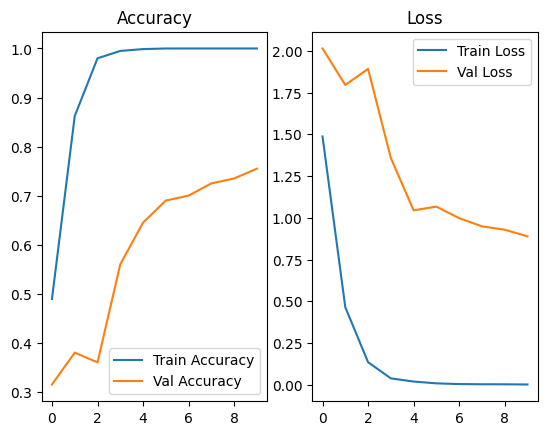

In [14]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7534 - loss: 0.9017

Test Accuracy: 75.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step

Classification Report:
              precision    recall  f1-score   support

       blues       0.87      0.65      0.74        20
   classical       0.95      0.90      0.92        20
     country       0.65      0.65      0.65        20
       disco       0.64      0.70      0.67        20
      hiphop       0.69      1.00      0.82        20
        jazz       0.75      0.90      0.82        20
       metal       0.95      0.90      0.92        20
         pop       0.86      0.60      0.71        20
      reggae       0.75      0.75      0.75        20
        rock       0.56      0.50      0.53        20

    accuracy                           0.76       200
   macro avg       0.77      0.76      0.75       200
weighted avg       0.77      0.76      0.75       200



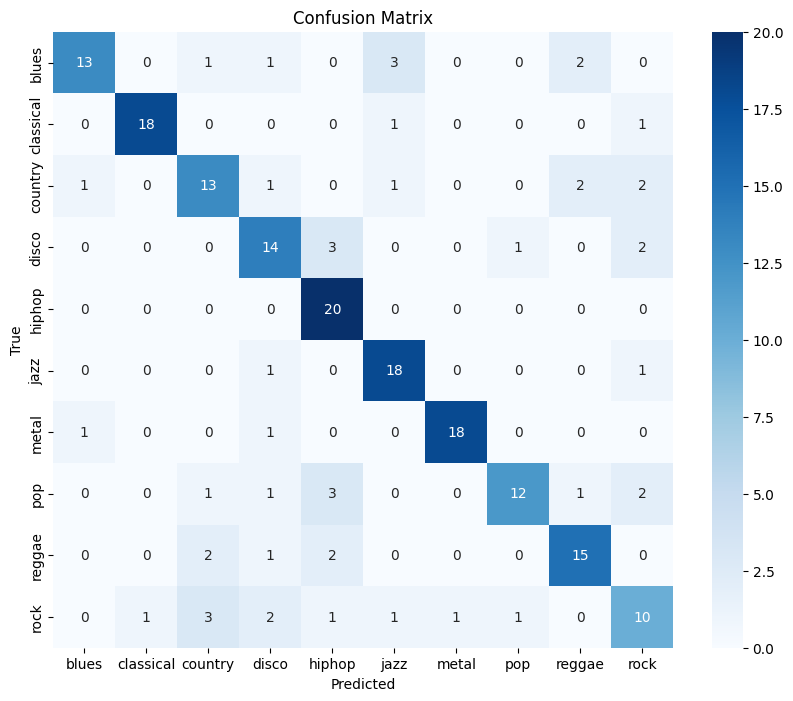

In [15]:
import seaborn as sns
# Evaluate accuracy
test_loss, test_acc = model.evaluate(X_test_resnet, y_test_cat)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Predictions
y_pred = model.predict(X_test_resnet)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
if y_test_cat.ndim > 1:  # one-hot encoded
    y_true_classes = np.argmax(y_test_cat, axis=1)
else:  # already integers
    y_true_classes = y_test_cat

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes),
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues",
            fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Work-on-tabular-data

In [16]:
df = pd.read_csv("/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [17]:
df.isna().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

In [18]:
df.duplicated().sum()

0

In [19]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [20]:
X = df.drop(columns=['filename', 'label'])  # drop filename and label
y = df['label']

In [21]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(n_estimators=200, random_state=42)

In [23]:
y_pred_rf = rf_model.predict(X_test_rf)


In [24]:

rf_acc = accuracy_score(y_test_rf, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_acc * 100:.2f}%")

Random Forest Test Accuracy: 78.50%


In [25]:
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=rf_model.classes_))


Classification Report:
              precision    recall  f1-score   support

       blues       0.80      0.80      0.80        20
   classical       0.83      0.95      0.88        20
     country       0.71      0.75      0.73        20
       disco       0.75      0.60      0.67        20
      hiphop       0.70      0.80      0.74        20
        jazz       0.76      0.80      0.78        20
       metal       0.89      0.85      0.87        20
         pop       0.86      0.90      0.88        20
      reggae       0.76      0.80      0.78        20
        rock       0.80      0.60      0.69        20

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200



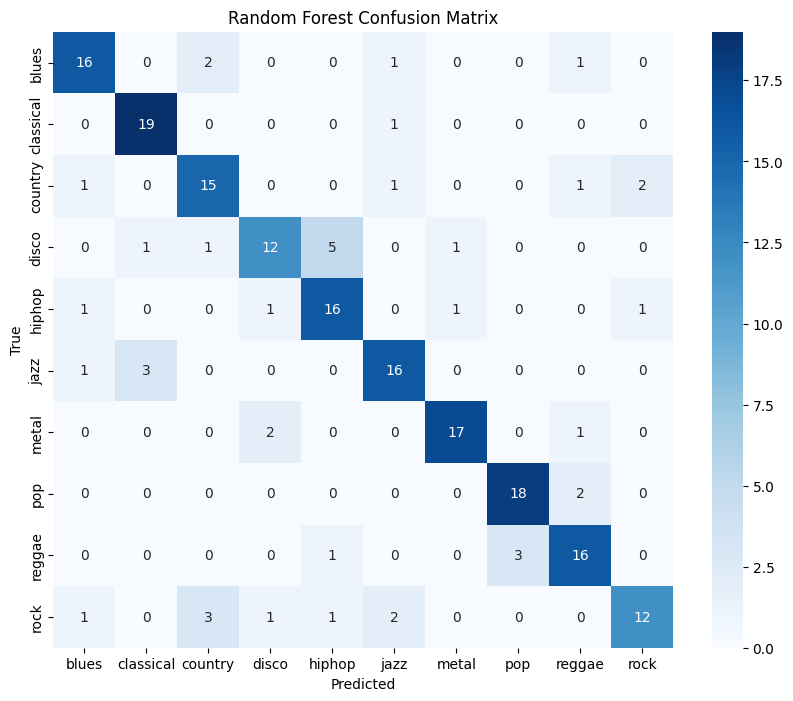

In [26]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_rf, y_pred_rf),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


## Compare between Images and Tabular 

In [27]:

# Compare with ResNet50 model
print(f"\nResNet50 Test Accuracy: {test_acc * 100:.2f}%")
print(f"Random Forest Test Accuracy: {rf_acc * 100:.2f}%")


ResNet50 Test Accuracy: 75.50%
Random Forest Test Accuracy: 78.50%
